## EMMA steps 2-4: PCA, EMMA model building, EMMA model validation
-----------------------------------------------------------------------

## This notebook defines 4 functions to perform the crucial steps for EMMA:

### 1. Event-based PCA: projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
#### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing (see other notebook)
####  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue.
#### - Event-based PCAs: take as function parameters: site, date range, list of endmembers, number of components (default is 2)
#### - I use scikit-learn's `pca.transform' to project the scaled endmember data into the vector space called by running `pca.fit_transform` on the scaled streamwater data.

### 2. Event-based EMMAs: takes as function parameters: site, date range, list of EMs.
#### - This notebook uses the SciPy packages's `constrained sequential least squares programming method for non-linear optimzation` (SLSQP, more details [here](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp)). This is similar to the [EMMALAB v. 1.1](https://www.hydroshare.org/resource/90ad78faec9f41c180d9057b9e815785/) use of MatLab's `fmincon` function (find minimum of constrained nonlinear multivariable function), details [here](https://www.mathworks.com/help/optim/ug/fmincon.html). I have another notebook that defines a similar function using constrained linear least squares for a linear optimization (CLLS).

### 3. Calculate EMMA-predicted tracer values for each streamwater sample.

### 4. Plot EMMA-predicted tracer values vs observed
-------------------------------------------------------------------------
## TO DO

- [ ] Add R^2 to function 4 tracer plots
- [ ] Add option for EM triangle bounding to PCA plots
- [ ] Add option for 1 STD error bars to PCA plots

In [85]:
#####################################
# PCA of streamwater and EMs ########
# Megan E Duffy 07/18/2025 ##########
# Part of EMMA workflow #############
# EVENT LEVEL PCA FOR EMMA ##########
#####################################

# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# Define event-specfic PCA plot function

def plot_event_pca(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, following the EMMALAB workflow:
    PCA is fit ONLY on streamwater (mixture) data, then endmembers are projected
    into that PCA space.

    Parameters:
        data (DataFrame): Full dataframe containing stream and endmember samples.
        site (str): Site name ("Wade" or "Hungerford").
        start_date (str or datetime): Start of storm event (e.g., "2023-04-01").
        end_date (str or datetime): End of storm event (e.g., "2023-04-04").
        endmember_ids (list of str): List of Sample IDs to use as endmembers.
        title (str): Title for the plot.
    """

    # Site-specific tracers
    if site == "PR Hailstone":
        tracers = ['d18O', 'dD', 'HCO3_mg_L', 'Si_mg_L', 'Mg_mg_L', 'K_mg_L', 'Ca_mg_L']
    elif site == "PR Soapstone":
        tracers = ['d18O', 'dD', 'HCO3_mg_L', 'Si_mg_L', 'Mg_mg_L', 'K_mg_L', 'Ca_mg_L']
    else:
        raise ValueError("Site not recognized. Use 'PR Hailstone' or 'PR Soapstone'.")
        
    # Ensure datetime column is datetime type
    data['Datetime'] = (data['Date'] + ' ' + data['Time']) # Combine the strings of original inventory Date and Time cols
    data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce") 
    data = data[data['Datetime'].notna()] # NA dates (we have a couple in the RI23 dataset) not useful - prune 

    # Subset streamwater (mixture) in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow"])) &
        (data["Datetime"] >= pd.to_datetime(start_date)) &
        (data["Datetime"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA for stream tracers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Datetime"] = stream["Datetime"]

    # Fill NA for endmembers with mean (per tracer)
    subset_endmembers = endmembers[tracers].copy()
    subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Datetime"] = endmembers["Datetime"].values

    # -----------------------
    # PCA logic 
    # -----------------------

    # 1. Fit scaler ONLY on streamwater using fit_transform
    scaler = StandardScaler()
    scaled_stream = scaler.fit_transform(subset_stream[tracers])

    # 2. PCA ONLY on scaled streamwater using pca.fit_transform
    pca = PCA(n_components=2)
    stream_pca_result = pca.fit_transform(scaled_stream)
    subset_stream["PC1"] = stream_pca_result[:, 0]
    subset_stream["PC2"] = stream_pca_result[:, 1]

    # 3. Project endmembers using same scaler & PCA using and transform and pca.transform
    scaled_endmembers = scaler.transform(subset_endmembers[tracers])
    endmember_pca_result = pca.transform(scaled_endmembers)
    subset_endmembers["PC1"] = endmember_pca_result[:, 0]
    subset_endmembers["PC2"] = endmember_pca_result[:, 1]

    # Combine for plotting
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # -----------------------
    # Plotting
    # -----------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot streamwater points
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Plot endmembers with distinct markers/colors #Original for BREE sites
    #endmember_markers = {
        #'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        #'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        #'Groundwater': 'D', 'Baseflow': 'P'
    #}

    endmember_markers = { #Adapted for Provo River
        'Snow': 's', 'Carbonate Groundwater': '^', 'Quartzite Groundwater': '*',
        'Soil Water': '<', 'Ephemeral Stream': 'o'
    }

    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e']
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em = combined[(combined["Type"] == etype)]
        if not em.empty:
            ax.scatter(em["PC1"], em["PC2"],
                       marker=endmember_markers[etype], c=color, edgecolors='black',
                       alpha=0.8, s=100, label=etype)
            for _, row in em.iterrows():
                if pd.notnull(row["Datetime"]):
                    ax.text(row["PC1"], row["PC2"], row["Datetime"].strftime('%m/%d'),
                            fontsize=12, ha='right')

    # Variance explained for axis labels
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Return info
    return tracers, pca, stream_pca_result

#########################
# STEP 2: EMMA FUNCTION #
#########################

def run_emma_event(data, site, start_date, end_date, endmember_ids, n_components=2):
    """
    Perform PCA-based End-Member Mixing Analysis (EMMA) for a storm event.
    
    Parameters:
        data (DataFrame): Full dataframe with streamwater and endmember data
        site (str): Site name ("Wade" or "Hungerford")
        start_date (str): Event start date (e.g., '2023-04-01')
        end_date (str): Event end date (e.g., '2023-04-04')
        endmember_ids (list of str): List of sample IDs to use as endmembers
        n_components (int): Number of principal components (default = 2)

    Returns:
        fractions_df (DataFrame): Streamwater samples with source fractions
    """
    
    # Site-specific tracers
    if site == "PR Hailstone":
        tracers = ['d18O', 'dD', 'HCO3_mg_L', 'Si_mg_L', 'Mg_mg_L', 'K_mg_L', 'Ca_mg_L']
    elif site == "PR Soapstone":
        tracers = ['d18O', 'dD', 'HCO3_mg_L', 'Si_mg_L', 'Mg_mg_L', 'K_mg_L', 'Ca_mg_L']
    else:
        raise ValueError("Site not recognized. Use 'PR Hailstone' or 'PR Soapstone'.")

    # Ensure datetime column is datetime type
    data['Datetime'] = (data['Date'] + ' ' + data['Time']) # Combine the strings of original inventory Date and Time cols
    data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce") 
    data = data[data['Datetime'].notna()] # NA dates (we have a couple in the RI23 dataset) not useful - prune 

    # --- Subset streamwater and endmembers ---
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow"])) &
        (data["Datetime"] >= pd.to_datetime(start_date)) &
        (data["Datetime"] <= pd.to_datetime(end_date))
    ].copy()

    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Clean + prepare
    stream_clean = stream[tracers].dropna().copy()
    stream_clean["Group"] = "Streamwater"
    stream_clean["Datetime"] = stream["Datetime"]

    end_clean = endmembers[tracers].copy()
    end_clean = end_clean.fillna(end_clean.mean())
    end_clean["Group"] = "Endmember"
    end_clean["Datetime"] = endmembers["Datetime"].values
    end_clean["Type"] = endmembers["Type"].values

    combined = pd.concat([stream_clean, end_clean], ignore_index=True)

    # --- PCA on combined data ---
    scaler = StandardScaler()
    scaled = scaler.fit_transform(combined[tracers])

    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled)

    combined["PC1"] = pca_result[:, 0]
    combined["PC2"] = pca_result[:, 1]

    # --- Separate stream and endmembers in PC space ---
    pc_cols = [f"PC{i+1}" for i in range(n_components)]
    stream_pcs = combined[combined["Group"] == "Streamwater"][pc_cols].values
    endmember_pcs = combined[combined["Group"] == "Endmember"][pc_cols].values
    endmember_labels = combined[combined["Group"] == "Endmember"]["Type"].values

    # --- EMMA optimization ---
    def objective(Ii, xi, B):
        xi_pred = np.dot(Ii, B)
        return np.linalg.norm(xi - xi_pred)

    constraints = (
        {'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},
        {'type': 'ineq', 'fun': lambda Ii: Ii},
        {'type': 'ineq', 'fun': lambda Ii: 1 - Ii},
    )

    fractions = []
    for xi in stream_pcs:
        init_guess = np.ones(endmember_pcs.shape[0]) / endmember_pcs.shape[0]
        result = minimize(objective, init_guess, args=(xi, endmember_pcs), constraints=constraints, method='SLSQP')
        fractions.append(result.x if result.success else np.nan)

    fractions = np.vstack(fractions)

    # --- Assemble output DataFrame ---
    fraction_cols = list(endmember_labels)
    stream_info = stream.reset_index(drop=True)[['Sample ID', 'Datetime', 'Site']]
    fractions_df = pd.concat([stream_info, pd.DataFrame(fractions, columns=fraction_cols)], axis=1)
    fractions_df["Sum_Fractions"] = fractions_df[fraction_cols].sum(axis=1)

    #return fractions_df, etc
    return fractions_df, scaler, pca, end_clean

##########################
# STEP 3. ERROR FUNCTION #
##########################

def predict_tracers_from_fractions(fractions_df, endmembers_df, tracer_cols):
    """
    Use EMMA fractions to predict tracer concentrations in streamwater samples.

    Parameters:
        fractions_df (DataFrame): Output from run_emma_event_fuss (includes fractions)
        endmembers_df (DataFrame): Subset of endmember data used in EMMA
        tracer_cols (list of str): List of tracer column names

    Returns:
        predicted_df (DataFrame): DataFrame with predicted tracer concentrations
    """
    # Unique endmember types used
    endmember_types = [col for col in fractions_df.columns if col in endmembers_df['Type'].unique()]

    # Get endmember mean tracer values by type
    em_means = endmembers_df.groupby("Type")[tracer_cols].mean()

    # Matrix of shape (n_endmembers, n_tracers)
    C = em_means.loc[endmember_types].values

    # Fractions matrix (n_samples, n_endmembers)
    F = fractions_df[endmember_types].values

    # Predicted concentrations (n_samples x n_tracers)
    predicted = np.dot(F, C)

    predicted_df = pd.DataFrame(predicted, columns=[f"{t}_predicted" for t in tracer_cols])
    predicted_df["Sample ID"] = fractions_df["Sample ID"]
    predicted_df["Datetime"] = fractions_df["Datetime"]

    return predicted_df

##############################################
# STEP 4. PLOT PREDICTED VS OBSERVED TRACERS #
##############################################

def plot_observed_vs_predicted(predicted_df, stream_df, tracer_cols):
    """
    Plot observed vs predicted tracer concentrations.

    Parameters:
        predicted_df (DataFrame): Output from predict_tracers_from_fractions
        stream_df (DataFrame): Original streamwater data
        tracer_cols (list): List of tracer names
    """
    merged = pd.merge(predicted_df, stream_df, on=["Sample ID", "Datetime"])

    import seaborn as sns

    n = len(tracer_cols)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]

    for i, tracer in enumerate(tracer_cols):
        ax = axes[i]
        ax.scatter(
            merged[tracer], 
            merged[f"{tracer}_predicted"],
            alpha=0.7
        )
        lims = [merged[[tracer, f"{tracer}_predicted"]].min().min(),
                merged[[tracer, f"{tracer}_predicted"]].max().max()]
        ax.plot(lims, lims, 'k--')
        ax.set_title(tracer)
        ax.set_xlabel("Observed")
        ax.set_ylabel("Predicted")

    plt.tight_layout()
    plt.show()

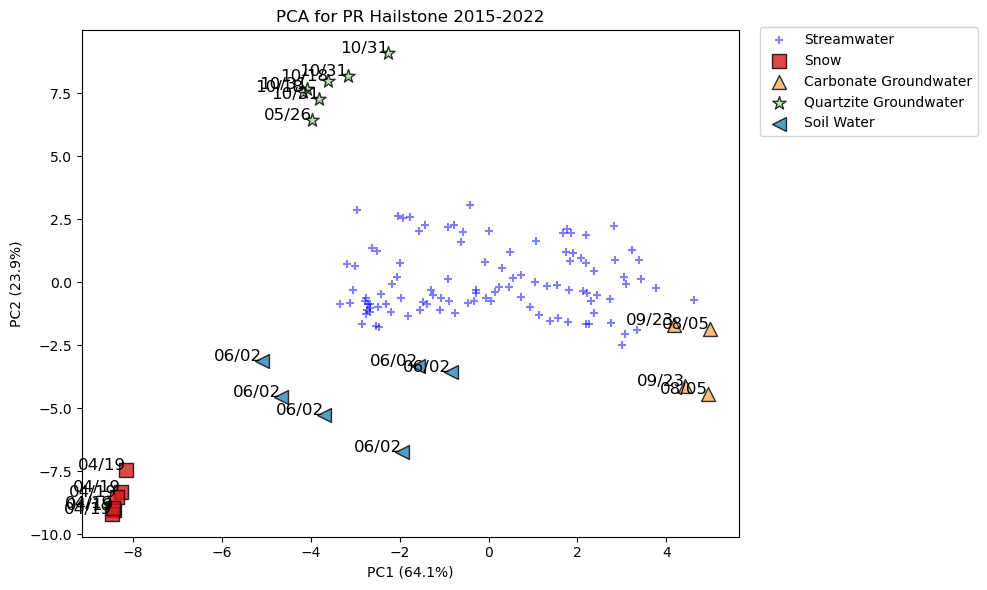

,Sample ID,Datetime,Site,Carbonate Groundwater,Quartzite Groundwater,Soil Water,Sum_Fractions
0,PR-12255,2015-10-28 12:00:00,PR Hailstone,0.649674,0.350326,1.010660e-13,1.0
1,PR-12278,2015-11-24 12:00:00,PR Hailstone,0.733437,0.237297,2.926582e-02,1.0
2,PR-12319,2016-01-14 12:00:00,PR Hailstone,0.709916,0.290084,-8.410022e-14,1.0
3,PR-12404,2016-03-08 12:00:00,PR Hailstone,0.660739,0.339261,1.358780e-13,1.0
4,PR-12408,2016-03-22 12:00:00,PR Hailstone,0.597759,0.402241,-7.301478e-14,1.0
...,...,...,...,...,...,...,...
101,PR-15764,2022-06-21 12:00:00,PR Hailstone,0.413675,0.260445,3.258797e-01,1.0
102,PR-15791,2022-06-28 12:00:00,PR Hailstone,0.444282,0.276747,2.789715e-01,1.0
103,PR-15811,2022-07-05 12:00:00,PR Hailstone,0.686602,0.313398,5.292523e-14,1.0
104,PR-15841,2022-07-19 12:00:00,PR Hailstone,0.709802,0.290198,1.196679e-13,1.0


In [92]:
# Load the full RI23 dataset
df = pd.read_csv("EMMALABv1.0/data/contents/ProvoRiverExampleDataset_forPythonMED.csv")

##############################################
# All Provo River Hailstone events 2011-2022 #
##############################################

# Step 1: PCA: Provo River Hailstone events 2015-2022
# To compare to EMMALAB v1.0 output
# Potential endmembers: 
    # Quartzite Groundwater: 10109, 10730, 11585, 10111, 10731, 11586, 12556
    # Carbonate Groundwater: 15927, 15928, 16033, 16034
    # Snow: 15263, 15264, 15265, 15266, 15267, 15268
    # Soil water: 15662, 15666, 15667, 15669, 15676, 15677

plot_event_pca(
    data=df,
    site="PR Hailstone",
    start_date="2011-10-27 00:00",
    end_date="2022-12-03 00:00",
    endmember_ids=["PR-10109", "PR-10730", "PR-11585", "PR-10111", \
                   "PR-10731", "PR-11586", "PR-12556", "PR-15927", \
                   "PR-15928", "PR-16033", "PR-16034", "PR-15263", "PR-15264", \
                   "PR-15265", "PR-15266", "PR-15267", "PR-15268", "PR-15662", \
                   "PR-15666", "PR-15667", "PR-15669", "PR-15676", "PR-15677"],
    #endmember_ids=["PR-CG", "PR-QG", "PR-SW"],
    title="PCA for PR Hailstone 2015-2022"
)

# Step 2: EMMA: Provo River Hailstone events 2015-2022
# To compare to EMMALAB v1.0 output
# Selected endmembers: 
    # Average Carbonate Groundwater PR-CG (I made in csv)
    # Average Quartzite Groundwater PR-QG 
    # Average Soil Water PR-SW

pr_hailstone_fractions_df, pr_hailstone_scaler, pr_hailstone_pca, pr_hailstone_endmembers_df = run_emma_event(
    data=df,
    site="PR Hailstone",
    start_date="2011-10-27 00:00",
    end_date="2022-12-03 00:00",
    endmember_ids=["PR-CG", "PR-QG", "PR-SW"]  
)

pr_hailstone_fractions_df